In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from simulation_utils import *
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, DistanceMetric, auc, f1_score, mutual_info_score
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
import scipy.stats as stat
from scipy.optimize import minimize
import itertools
# import ipyparallel as ipp
from collections import defaultdict
import pymc as pm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon
import matplotlib.animation as animation


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
weightedStructuredGraph = np.array([
[0, 24, 24, 24, 24, 24, 5, 5, 5, 5, 5, 5],
[24, 0, 24, 24, 24, 24, 5, 5, 5, 5, 5, 5],
[24, 24, 0, 24, 24, 24, 5, 5, 5, 5, 5, 5],
[24, 24, 24, 0, 24, 24, 5, 5, 5, 5, 5, 5],
[24, 24, 24, 24, 0, 24, 5, 5, 5, 5, 5, 5],
[24, 24, 24, 24, 24, 0, 5, 5, 5, 5, 5, 5],
[5, 5, 5, 5, 5, 5, 0, 24, 24, 24, 24, 24],
[5, 5, 5, 5, 5, 5, 24, 0, 24, 24, 24, 24],
[5, 5, 5, 5, 5, 5, 24, 24, 0, 24, 24, 24],
[5, 5, 5, 5, 5, 5, 24, 24, 24, 0, 24, 24],
[5, 5, 5, 5, 5, 5, 24, 24, 24, 24, 0, 24],
[5, 5, 5, 5, 5, 5, 24, 24, 24, 24, 24, 0],
])

weightedUnStructuredGraph = np.array([
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])

item_vectors = np.array([
       [1, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1]])

In [3]:
def weightedRandomWalk(weightedGraph, pathLength):
    startState = np.random.choice(weightedGraph.shape[0])
    currentState = startState
    path = []
    
    for i in range(pathLength):
        chosen_neighbor = np.random.choice(range(weightedGraph.shape[0]), p=weightedGraph[currentState]/np.sum(weightedGraph[currentState]))
        path.append(currentState)
        currentState = chosen_neighbor        
    return np.array(path)


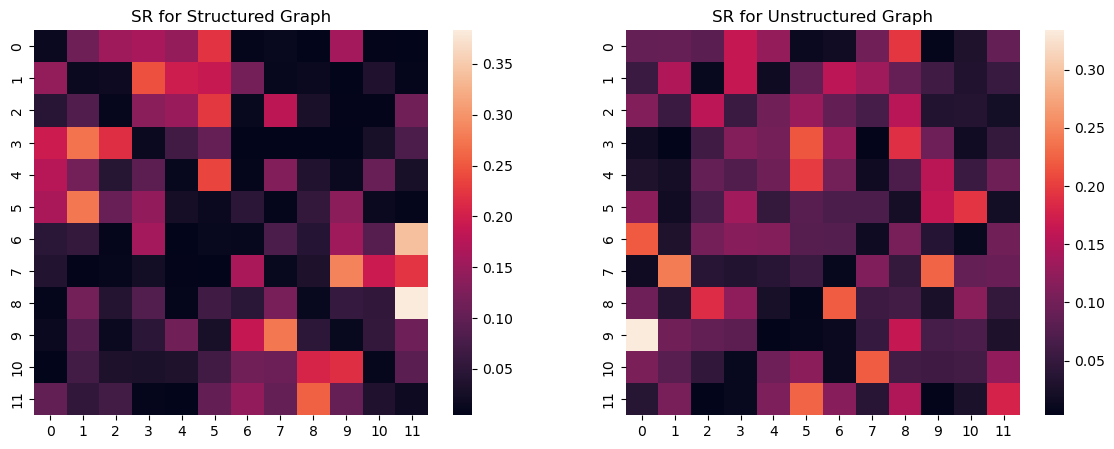

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
SR = run_SR(weightedRandomWalk(weightedStructuredGraph, 1000), weightedStructuredGraph, alpha=0.1,gamma=0.1, plot=False)[0]
sns.heatmap(SR, ax=ax[0])
SR = run_SR(weightedRandomWalk(weightedUnStructuredGraph, 1000), weightedUnStructuredGraph, plot=False)[0]
sns.heatmap(SR, ax=ax[1])
ax[0].set_title('SR for Structured Graph')
ax[1].set_title('SR for Unstructured Graph')
plt.savefig('figures/category-sr-sims.png', dpi = 300, transparent = True)


In [5]:
def get_feat_weight_vector(SR_matrix):
    feature_weight_vector = np.zeros(8)
    for item_a, item_b in itertools.combinations(np.arange(12), 2):
        feature_indices = np.arange(8)[item_vectors[item_a] == item_vectors[item_b]]
        feature_weight_vector[feature_indices] = feature_weight_vector[feature_indices] + np.mean([SR_matrix[item_a][item_b], SR_matrix[item_a][item_b]])    
        # feature_weight_vector = np.sum(feat_matrix, axis = 0)
    return feature_weight_vector

In [127]:
fwv = get_feat_weight_vector(SR)

In [12]:
def get_choices(feature_weight_vector, multiplier):
    choices = []
    for num_feats in [1, 2, 3, 4]:
        for test_item in item_vectors:

            cat_option_featchange_idx = np.random.choice(range(4, 8), size=num_feats, replace=False)
            noncat_option_featchange_idx = np.random.choice(range(0, 4), size = num_feats, replace=False)

            cat_option = test_item.copy()
            noncat_option = test_item.copy()
            cat_option[cat_option_featchange_idx] = 1 - cat_option[cat_option_featchange_idx]
            noncat_option[noncat_option_featchange_idx] = 1 - noncat_option[noncat_option_featchange_idx]
            cat_dist = 0
            noncat_dist = 0
            for feat in range(8):
                cat_dist += (multiplier*feature_weight_vector[feat])*np.bitwise_xor(test_item[feat], cat_option[feat])
                noncat_dist += (multiplier*feature_weight_vector[feat])*np.bitwise_xor(test_item[feat], noncat_option[feat])
            # print(cat_dist, noncat_dist)
            cat_sim = np.exp(-cat_dist)
            noncat_sim = np.exp(-noncat_dist)

            p_cat_choice = cat_sim/(cat_sim + noncat_sim)
            # print(p_cat_choice)
            choices.append(np.random.uniform(0, 1) < p_cat_choice)
    return choices


In [13]:
param_itr = itertools.product(np.arange(10), [0.01, 0.1, 0.25, 0.5, 0.75, 0.9], [0.01, 0.1, 0.25, 0.5, 0.75, 0.9], [1, -1])
params = np.array([p for p in param_itr])
choices = []
# for p in params:
#     walk = weightedRandomWalk(weightedStructuredGraph, 300)
#     SR = run_SR(walk, weightedStructuredGraph, p[0], )
choices = [get_choices(get_feat_weight_vector(run_SR(weightedRandomWalk(weightedStructuredGraph, 300), weightedStructuredGraph, alpha=p[1], gamma=p[2], plot=False)[0]), p[3]) 
           for p in params]

structured_cat_df = pd.DataFrame({'choices': np.ravel(choices), 
                       'iteration' : np.repeat(params[:, 0], 48),
                       'num_feats': np.tile(np.repeat(np.arange(1, 5), 12), params.shape[0]),
                       'alpha': np.repeat(params[:, 1], 48),
                       'gamma': np.repeat(params[:, 2], 48),
                       'base_weight': np.repeat(params[:, 3], 48)
              })
structured_cat_df['graph type'] = 'structured'

In [15]:
param_itr = itertools.product(np.arange(10), [0.01, 0.1, 0.25, 0.5, 0.75, 0.9], [0.01, 0.1, 0.25, 0.5, 0.75, 0.9], [1, -1])
params = np.array([p for p in param_itr])
choices = [get_choices(get_feat_weight_vector(run_SR(weightedRandomWalk(weightedUnStructuredGraph, 300), weightedUnStructuredGraph, alpha=p[1], gamma=p[2], plot=False)[0]), p[3]) 
           for p in params]

unstructured_cat_df = pd.DataFrame({'choices': np.ravel(choices), 
                       'iteration' : np.repeat(params[:, 0], 48),
                       'num_feats': np.tile(np.repeat(np.arange(1, 5), 12), params.shape[0]),
                       'alpha': np.repeat(params[:, 1], 48),
                       'gamma': np.repeat(params[:, 2], 48),
                       'base_weight': np.repeat(params[:, 3], 48)
              })
unstructured_cat_df['graph type'] = 'unstructured'

In [16]:
cat_df = pd.concat([structured_cat_df, unstructured_cat_df])

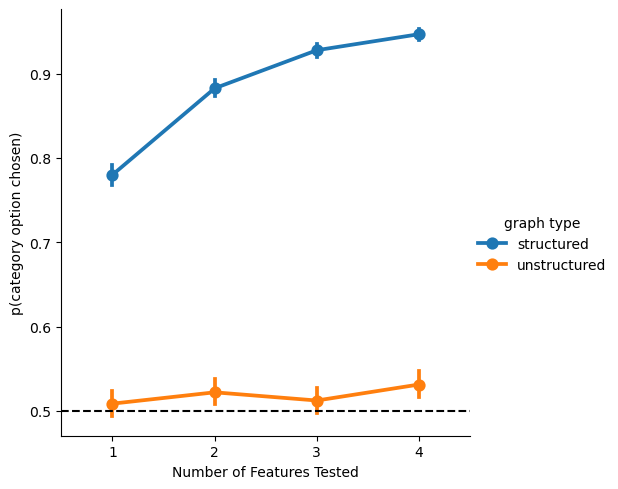

In [21]:
g = sns.catplot(y = 'choices', 
            x = 'num_feats', hue = 'graph type', #col = 'base_weight',
            data = cat_df.loc[cat_df.base_weight == 1.0], 
            kind = 'point',
            )
g.axes[0][0].axhline(y = 0.5, ls = '--', color = 'black')
# g.axes[0][1].axhline(y = 0.5, ls = '--', color = 'black')

g.axes[0][0].set_ylabel('p(category option chosen)')
g.axes[0][0].set_xlabel('Number of Features Tested')

plt.savefig('figures/cat_simulations.png', dpi = 300, transparent = True)

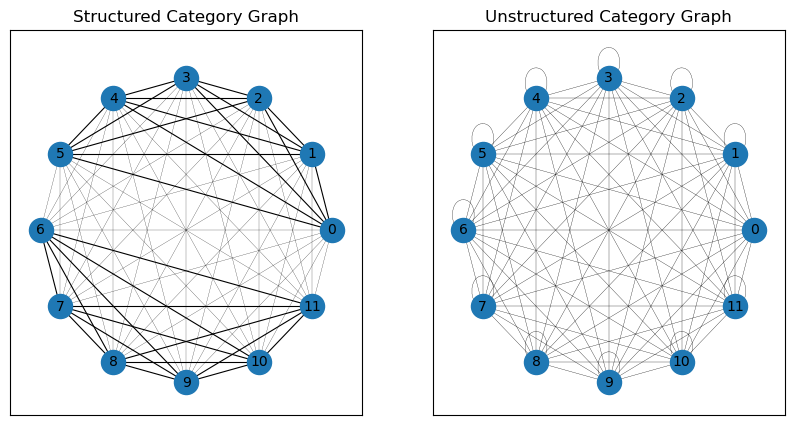

In [176]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
G = nx.Graph()
for i in range(12):
    for j in range(1, 12):
        G.add_edge(i, j, weight = weightedStructuredGraph[i][j])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax[0])
nx.draw_networkx_edges(G, pos, edgelist = [(u, v) for (u, v, d) in G.edges(data=True)], width= [d['weight']/30 for (u, v, d) in G.edges(data=True)], ax = ax[0])
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", ax=ax[0])
ax[0].set_title('Structured Category Graph')


G = nx.Graph()
for i in range(12):
    for j in range(1, 12):
        G.add_edge(i, j, weight = weightedUnStructuredGraph[i][j])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax[1])
nx.draw_networkx_edges(G, pos, edgelist = [(u, v) for (u, v, d) in G.edges(data=True)], width= [d['weight']/4.5 for (u, v, d) in G.edges(data=True)], ax = ax[1])
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", ax=ax[1])
ax[1].set_title('Unstructured Category Graph')


plt.savefig('figures/cat_graphs.png', dpi = 300, )

In [251]:
 np.ravel([[0, 0, 0, 0, 0, 1, 0, 1], 
                                          [0, 1, 0, 1, 0, 0, 0, 0],
                                          [0, 1, 0, 0, 0, 0, 0, 1],
                                          [0, 0, 0, 1, 0, 1, 0, 0],
                                          [0, 1, 0, 0, 0, 1, 0, 0],
                                          [0, 0, 0, 1, 0, 0, 0, 1],
                                          [1, 0, 1, 0, 1, 1, 1, 1], 
                                          [1, 1, 1, 1, 1, 0, 1, 0],
                                          [1, 1, 1, 0, 1, 0, 1, 1],
                                          [1, 0, 1, 1, 1, 1, 1, 0],
                                          [1, 1, 1, 0, 1, 1, 1, 0],
                                          [1, 0, 1, 1, 1, 0, 1, 1],
                                          ])

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1])

In [264]:
pd.DataFrame({'Feature Dimensions': np.repeat(['Color', 'Shape', 'Size', 'Orientation'], 2*12), 
              'Feature Elements': np.tile(['Head', 'Torso', 'Nose', 'Bellybutton', 'Eyes', 'Arms', 'Antenna', 'Feet'], 12),
              'Feature Values': np.ravel([[0, 0, 0, 0, 0, 1, 0, 1], 
                                          [0, 1, 0, 1, 0, 0, 0, 0],
                                          [0, 1, 0, 0, 0, 0, 0, 1],
                                          [0, 0, 0, 1, 0, 1, 0, 0],
                                          [0, 1, 0, 0, 0, 1, 0, 0],
                                          [0, 0, 0, 1, 0, 0, 0, 1],
                                          [1, 0, 1, 0, 1, 1, 1, 1], 
                                          [1, 1, 1, 1, 1, 0, 1, 0],
                                          [1, 1, 1, 0, 1, 0, 1, 1],
                                          [1, 0, 1, 1, 1, 1, 1, 0],
                                          [1, 1, 1, 0, 1, 1, 1, 0],
                                          [1, 0, 1, 1, 1, 0, 1, 1],
                                          ]),
              'Stimulus': np.repeat(np.arange(1, 13), 8)
              }).pivot(index = 'Stimulus', columns = ['Feature Elements'], values = 'Feature Values').to_latex('feature_table.txt')


In [236]:
list('{:04b}'.format(1))

['0', '0', '0', '1']